In [1]:
import os

import random

import torch


import numpy as np

from pycocotools.coco import COCO

import torchvision
from torchvision.io import read_image

from torchvision.transforms import v2 as T

from torchvision.utils import draw_bounding_boxes


import matplotlib.pyplot as plt
from torchvision import tv_tensors
from pickle import load
from numpy import arange

from pickle import load, dump, HIGHEST_PROTOCOL

import torch.utils.data as data

In [2]:
class TrainingsDataset(torch.utils.data.Dataset):
    def __init__(self, labels, transforms=None):
        self.labels = labels
        self.transforms = transforms
    

    def __getitem__(self, index):
        coco = self.labels[index]["coco"]
        root = self.labels[index]["root"]
        img_id = self.labels[index]["image_id"]
        path = coco.loadImgs(img_id)[0]['file_name']
        
        img = read_image(os.path.join(root, path))
        img = tv_tensors.Image(img)
        
        my_annotation = {}
        my_annotation["boxes"] = self.labels[index]["boxes"]
        my_annotation["labels"] = self.labels[index]["labels"]
        my_annotation["image_id"] = img_id
        my_annotation["area"] = self.labels[index]["area"]
        my_annotation["iscrowd"] = self.labels[index]["iscrowd"]
       
        if self.transforms is not None:
            img, my_annotation = self.transforms(img, my_annotation)

        return img, my_annotation, root

    def __len__(self):
        return len(self.labels)

In [3]:
def get_transform(train, h_flip, v_flip):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(h_flip))
        transforms.append(T.RandomVerticalFlip(v_flip))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [4]:
path_base = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'Data', 'data_sorted')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torch.load(os.path.dirname(os.getcwd()) + "\\Object_Detection\\Models\\model_whole_no_empty.pt", weights_only=False)
model.to(device)
with open(os.path.dirname(os.getcwd()) + "\\Object_Detection\\dataloaders\\names_to_annotation_no_empty.pkl", "rb") as input_file:
   names_to_annotation = load(input_file)

#model_no_empty = torch.load(os.path.dirname(os.getcwd()) + "\\Object_Detection\\Models\\model_no_empty.pt")
#model_no_empty.to(device)

In [5]:
with open(os.path.dirname(os.getcwd()) + "\\Object_Detection\\dataloaders\\labels_no_empty.pkl", "rb") as input_file:
   annotated_labels = load(input_file)

In [ ]:
len(annotated_labels)

In [ ]:
annotated_labels[0]

In [7]:
annotated_ds = []
annotated_ds.append(TrainingsDataset(annotated_labels, transforms=get_transform(train=True, h_flip=0, v_flip=0)))
annotated_ds.append(TrainingsDataset(annotated_labels, transforms=get_transform(train=True, h_flip=1, v_flip=0)))
annotated_ds.append(TrainingsDataset(annotated_labels, transforms=get_transform(train=True, h_flip=0, v_flip=1)))
annotated_ds.append(TrainingsDataset(annotated_labels, transforms=get_transform(train=True, h_flip=1, v_flip=1)))

concat_ds = data.ConcatDataset(annotated_ds)

#Setup: Train-Validation-Split & Dataloaders
generator1 = torch.Generator().manual_seed(99)
annotated_ds_train, annotated_ds_test = data.random_split(concat_ds, [0.8, 0.2], generator=generator1)

In [ ]:
annotated_ds[0][0]

In [ ]:
#Visualize original Bounding Boxes

'''test_video = 'p2_v5'
img_id = 226'''

test_video = 'p2_v5'
img_id = 230

#img_id = 2765

'''
test_video = 'p2_v5'
img_id = 4276


test_video = 'p1_v4'
img_id = 3500'''


coco = COCO(os.path.join(path_base, 'labels', 'COCO', test_video+'.json'))
ids = list(sorted(coco.imgs.keys()))

path = coco.loadImgs(img_id)[0]['file_name'] 
image = read_image(os.path.join(path_base, 'frames', test_video, path))

'''image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]'''

annIds = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(annIds)

categories = []
bboxes = []

for i in anns:
    categories.append(coco.loadCats(i['category_id'])[0]["name"])
    xmin = i['bbox'][0]
    ymin = i['bbox'][1]
    xmax = xmin + i['bbox'][2]
    ymax = ymin + i['bbox'][3]
    bboxes.append(torch.as_tensor([xmin, ymin, xmax, ymax]))


bboxes = torch.stack(bboxes)

output_image = draw_bounding_boxes(image, bboxes, categories, colors=["red", "blue", "green", "orange", "violet", "pink", "cyan"])

img = torchvision.transforms.ToPILImage()(output_image)

img.show()

In [ ]:
bboxes

In [ ]:
#Predict and visualize Bounding Boxes for one Image

test_video = 'p2_v5'
img_id = 230


'''
test_video = 'p2_v5'
img_id = 4276


test_video = 'p1_v4'
img_id = 3500'''

coco = COCO(os.path.join(path_base, 'labels', 'COCO', test_video+'.json'))
ids = list(sorted(coco.imgs.keys()))

path = coco.loadImgs(img_id)[0]['file_name'] 
image = read_image(os.path.join(path_base, 'frames', test_video, path))

eval_transform = get_transform(train=False, h_flip=0, v_flip=0)

#model.eval()
#model_no_empty.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    #predictions = model_no_empty([x, ])
    pred = predictions[0]

annIds = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(annIds)

'''image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]'''

cats = []
scores = []
pred_boxes = []

for x in range(len(pred["boxes"])):
    if pred["scores"][x] >= 0.0:
        y = pred["labels"][x].item()
        z = names_to_annotation.inv.get(y)
        cats.append(z)
        scores.append(pred["scores"][x].item())
        pred_boxes.append(pred["boxes"][x])

pred_labels_sure = []
for x in range(len(cats)):
    pred_labels_sure.append(f"{cats[x]}: {scores[x]:.5f}")


pred_boxes = torch.stack(pred_boxes)

output_image = draw_bounding_boxes(image, pred_boxes, pred_labels_sure, colors=["red", "blue", "green", "orange", "violet", "pink", "cyan", "beige", "black", "crimson", "yellow"])

img = torchvision.transforms.ToPILImage()(output_image)

img.show()

In [ ]:
annotated_ds_test[0][1]

In [ ]:
bboxes

In [ ]:
pred_boxes

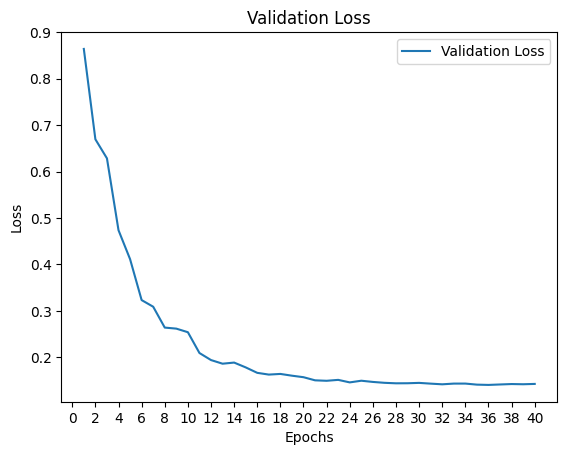

In [3]:
# Load the training and validation loss dictionaries
val_loss = load(open(os.path.dirname(os.getcwd()) + "\\Object_Detection\\training_output\\lval_loss_no_empty.pkl", 'rb'))
 
# Retrieve each dictionary's values
val_values = []

for x in val_loss:
    val_values.append(val_loss[x].item())
 
y = len(val_values)+1
# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, y)
 
# Plot and label the training and validation loss values
plt.plot(epochs, val_values, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(arange(0, y, 2))
 
# Display the plot
plt.legend(loc='best')
plt.show()

Testing after training 

In [8]:
from torchmetrics.detection import MeanAveragePrecision
from tqdm import tqdm

In [9]:
preds_0 = []
preds_75 = []
targets_0 = []
targets_75 = []

In [10]:
device

device(type='cuda')

In [ ]:
#Filter bounding boxes with score<0.75

for test_frame in tqdm(annotated_ds_test):

    test_video = test_frame[2].split('\\')[-1]
    img_id = test_frame[1]['image_id']

    coco = COCO(os.path.join(path_base, 'labels', 'COCO', test_video+'.json'))
    ids = list(sorted(coco.imgs.keys()))

    path = coco.loadImgs(img_id)[0]['file_name'] 
    image = read_image(os.path.join(path_base, 'frames', test_video, path))

    eval_transform = get_transform(train=False, h_flip=0, v_flip=0)

    #model.eval()
    #model_no_empty.eval()
    with torch.no_grad():
        x = eval_transform(image)
        # convert RGBA -> RGB and move to device
        x = x[:3, ...].to(device)
        predictions = model([x, ])
        #predictions = model_no_empty([x, ])
        pred = predictions[0]

    annIds = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(annIds)

    categories = []
    bboxes = []

    for i in anns:
        categories.append(names_to_annotation[coco.loadCats(i['category_id'])[0]["name"]])
        xmin = i['bbox'][0]
        ymin = i['bbox'][1]
        xmax = xmin + i['bbox'][2]
        ymax = ymin + i['bbox'][3]
        bboxes.append(torch.as_tensor([xmin, ymin, xmax, ymax]))

    bboxes = torch.stack(bboxes)

    target_0 = {}
    target_0['boxes'] = bboxes.to(device)
    target_0['labels'] = torch.as_tensor(categories).to(device)
    targets_0.append(target_0)

    target_75 = {}
    target_75['boxes'] = bboxes.to(device)
    target_75['labels'] = torch.as_tensor(categories).to(device)

    pred_0 = {}
    pred_0['boxes'] = pred['boxes'].to(device)
    pred_0['scores'] = pred['scores'].to(device)
    pred_0['labels'] = pred['labels'].to(device)
    preds_0.append(pred_0)

    cats = []
    scores = []
    pred_boxes = []           
    
    for x in range(len(pred["boxes"])):
        if pred["scores"][x] >= 0.75:
            y = pred["labels"][x].item()
            cats.append(y)
            scores.append(pred["scores"][x].item())
            pred_boxes.append(pred["boxes"][x])
    
    pred_75 = {}
    try:
        pred_75['boxes'] = torch.stack(pred_boxes).to(device)
        pred_75['scores'] = torch.as_tensor(scores).to(device)
        pred_75['labels'] = torch.as_tensor(cats).to(device)
        preds_75.append(pred_75)
        
        targets_75.append(target_75)
    except:
        print('skipped')   

In [ ]:
len(annotated_ds_test)

In [ ]:
print(len(preds_0), len(targets_0), len(preds_75), len(targets_75))

In [14]:
# Compute Mean average precision for the unfiltered & filtered bounding boxes

metric_0 = MeanAveragePrecision(iou_type="bbox")
metric_75 = MeanAveragePrecision(iou_type="bbox")
metric_0.update(preds_0, targets_0)
metric_75.update(preds_75, targets_75)

In [15]:
metric_0.compute()

{'map': tensor(0.9483),
 'map_50': tensor(0.9913),
 'map_75': tensor(0.9829),
 'map_small': tensor(0.7369),
 'map_medium': tensor(0.8549),
 'map_large': tensor(0.9533),
 'mar_1': tensor(0.8640),
 'mar_10': tensor(0.9653),
 'mar_100': tensor(0.9653),
 'mar_small': tensor(0.7435),
 'mar_medium': tensor(0.8784),
 'mar_large': tensor(0.9702),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.)}

In [16]:
metric_75.compute()

{'map': tensor(0.9478),
 'map_50': tensor(0.9904),
 'map_75': tensor(0.9829),
 'map_small': tensor(0.7369),
 'map_medium': tensor(0.8542),
 'map_large': tensor(0.9528),
 'mar_1': tensor(0.8636),
 'mar_10': tensor(0.9647),
 'mar_100': tensor(0.9647),
 'mar_small': tensor(0.7435),
 'mar_medium': tensor(0.8777),
 'mar_large': tensor(0.9697),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.)}